# Tennis Match Prediction
#### By: Alejandro Velasquez, Chloe Whitaker, Daniel Northcutt, Mason Sherbondy

## Project Goals:
- Create a tennis match predictor that will determine the outcome of a match
- Explore and compare the great rivalries of current tennis stars
- Create a model to predict if a player will reach the top 30 ranking by valuating their first 30 games


## Initial Questions:
- Does a difference in career average break points saved impact victory?

- Does a difference in career average break points won impact victory?

- Does a difference in career percent-of-break-points-won impact victory?

- Does a difference in average forehand winners impact victory?

- Does a difference in average backhand winners impact victory?

- What are the drivers that determine a change in the dynamic between two players? Is there anything in our data set to suggest a change in dynamic?

- How do key rivalries play out in best of 3 matches vs best of 5? Do rivalries take a different story at Grand Slam events?

- How do key rivalries play out on clay? On grass? On hard court?

- What characteristics and trends determine a player to become a top 30?

- Does surface performance predict a player's future rank?

In [20]:
# imports

import pandas as pd
import numpy as np
import regex as re

# Custom Helper Files
from prepare import *
from explore import *

# Split 
from sklearn.model_selection import train_test_split

# Stats
from scipy import stats

# Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Remove Limits On Viewing Dataframes
pd.set_option('display.max_columns', None)

## Executive Summary:

## Acquire:

- Data was acquired from repo collecting Men's ATP tennis match data from 1968 - 2019
- https://github.com/JeffSackmann (source)
- Collected 180k rows of data

## ATPTotal Prepare:
- Randomized winner & loser as player1 and player2 alphabetically 
- Filtered for matches between 1999-01-01 to 2020-01-01
- Removed all Walk Offs and best of 1 matches
- Set our index to tourney date w/ format to %Y%m%d
- Dropped all values that did not provide full match statistics
- Filtered out players that played less than 50 matches
- 36000 matches

## PlayerDatabase Prepare:
- (Same prepares steps above)
- Filtered for players that hit a max rank of 100 or better
- Aggregated full stats for Aces, Breakpoints, Double Faults, Wins, and First Serve Win by Match
- Aggregated career performance by court surface (hard, grass, clay, carpet)
- Aggregated first 30 matches statistics - later use to predict future ranking


In [3]:
# pulling function - 35969 matches
df = prepare_atp()
df.shape

(35969, 80)

In [11]:
# confirm prepare
df.head(1)

,tourney_id,draw_size,winner,surface,tourney_level,best_of,player_1,player_2,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_wins,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,player_1_hand_R,player_1_hand_L,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-11,1999-338,32,Lleyton Hewitt,Hard,A,3,Lleyton Hewitt,Patrick Rafter,17.878166,26.036961,R,R,180.0,185.0,AUS,AUS,Lleyton Hewitt,Patrick Rafter,104.0,4.0,456.0,3315.0,True,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,104.0,4.0,-5.0,-8.158795,100.0,-2859.0,False,1999


In [7]:
# # Pulling Player Database aggregated stats of players within the time span
# PlayerData = pd.read_csv('PlayerData.csv')
# PlayerData.shape

In [8]:
## PlayerDatabase of 371 players that hit a maxrank of at least 100 and have 50 or more games
#PlayerData.head()

In [12]:
# confirm clean
df = clean_for_model(df)

In [13]:
# split the data into train, validate, and test so that we can conform there is not overfitting on our model
train, validate, test = train_validate_test_split(df)

## Explore

### What drives winning? 

Plan for explore:

To identify features to use in modeling, separate the groups by wins / losses and then see if there was a significant difference between variables in that group. For exapmple: I'll take all of the matches that player1 wins and get the mean rank points for player1 for that group then do the same for all of the matches where player1 loses. If there is a significant difference then hight is likely a driver of winning and losing.

In [15]:
# seperate player 1 wins and losses into dfs
player_1_w = train[train['player_1_wins'] == True]
player_1_l = train[train['player_1_wins'] == False]

In [16]:
# confirm wins df
player_1_w.head(1)

,tourney_id,draw_size,winner,surface,tourney_level,best_of,player_1,player_2,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_wins,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,player_1_hand_R,player_1_hand_L,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-05-26,2003-520,128,Andre Agassi,Clay,G,5,Andre Agassi,Karol Beck,33.073238,21.144422,R,R,180.0,180.0,USA,SVK,Andre Agassi,Karol Beck,2.0,73.0,3900.0,575.0,True,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,2.0,73.0,0.0,11.928816,-71.0,3325.0,True,2003


In [17]:
# confirm losses df
player_1_l.head(1)

,tourney_id,draw_size,winner,surface,tourney_level,best_of,player_1,player_2,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_wins,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,player_1_hand_R,player_1_hand_L,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-09-13,2004-773,32,Igor Andreev,Clay,A,3,Florian Mayer,Igor Andreev,20.941821,21.169062,R,R,190.0,185.0,GER,RUS,Florian Mayer,Igor Andreev,36.0,49.0,879.0,727.0,False,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,49.0,36.0,5.0,-0.227242,-13.0,152.0,False,2004


#### Does player_1_rank_points impact player_1_wins? 

I will check to see if the average ranking points when player 1 wins is not the same as when player 1 loses.

In [18]:
# Rank points
print('Average rank points, all matches: ' + str(train['player_1_rank_points'].mean()))
print('Average rank points, player 1 wins: ' + str(player_1_w['player_1_rank_points'].mean()))
print('Average rank points, player 1 loses: ' + str(player_1_l['player_1_rank_points'].mean()))
print('\n')

Average rank points, all matches: 1325.310136685623
Average rank points, player 1 wins: 1619.625488582596
Average rank points, player 1 loses: 1048.1565284773344




It does look like there's a significant difference in the average rank points amongst wins and losses.

I will confirm that with stats and a visual: 

In [42]:
# We want to be sure that the effect we see isn't explained by chance, so I will use a confidance interval of 95%
# The resulting alpha is .05.
null_hypothesis = "The average ranking points when player 1 wins is the same as when player 1 loses."
alternative_hypothesis = "The average ranking points when player 1 wins is not the same as when player 1 loses." 
alpha = 0.01

In [26]:
get_ttest_rank_points(train)

t = -375376.000
p = 0.000


In [28]:
p = 0.000
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    print("Our evidence does not support the claim that the average ranking points when player 1 wins is not the same as when player 1 loses")


We reject the null hypothesis that The average ranking points when player 1 wins is the same as when player 1 loses.
We move forward with the alternative hypothesis that The average ranking points when player 1 wins is not the same as when player 1 loses.


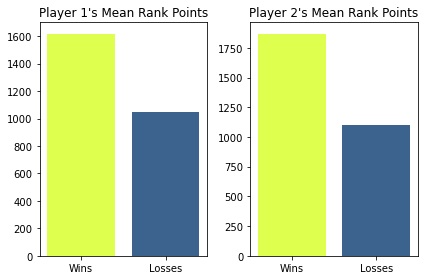

In [29]:
get_winning_player_rank_points(train)

##### Does player_1_hand_R impact player_1_wins?

I will check to see if there is a dependence between right hand used and player 1 winning using stats: 

In [37]:
# We want to be sure that the effect we see isn't explained by chance, so I will use a confidance interval of 95%
# The resulting alpha is .05.
null_hypothesis = "There is no dependence between right hand used and player 1 winning"
alternative_hypothesis = "There is a dependence between right hand used and player 1 winning"
alpha = 0.05

In [30]:
get_chi_right_hand(train)

chi^2 = 7.7200
p = 0.0055


In [36]:
p = 0.0055
if p < alpha:
    print("We reject the null that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    print("Evidence does not support", alternative_hypothesis)

We reject the null that There is no dependence between right hand used and player 1 winning
We move forward with the alternative hypothesis that There is a dependence between right hand used and player 1 winning


##### Does player_1_hand_L impact player_1_wins?

I will check to see if There is a dependence between left hand used and player 1 winning using stats:

In [39]:
# We want to be sure that the effect we see isn't explained by chance, so I will use a confidance interval of 95%
# The resulting alpha is .05.
null_hypothesis = "There is no dependence between left hand used and player 1 winning"
alternative_hypothesis = "There is a dependence between left hand used and player 1 winning"
alpha = 0.05

In [31]:
get_chi_left_hand(train)

chi^2 = 7.7200
p = 0.0055


In [40]:
p = 0.0055
if p < alpha:
    print("We reject the null that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    print("Evidence does not support", alternative_hypothesis)

We reject the null that There is no dependence between left hand used and player 1 winning
We move forward with the alternative hypothesis that There is a dependence between left hand used and player 1 winning


##### Does surface_clay impact player_1_wins?

I will check to see if there is a dependence between clay surface used and player 1 winning using stats and a visual.

In [43]:
# We want to be sure that the effect we see isn't explained by chance, so I will use a confidance interval of 95%
# The resulting alpha is .05.
null_hypothesis = "There is no dependence between clay surface and player 1 winning"
alternative_hypothesis = "There is a dependence between clay surface used and player 1 winning"
alpha = 0.05

In [44]:
get_chi_clay(train)

chi^2 = 8.7153
p = 0.0032


In [45]:
p = 0.0032
if p < alpha:
    print("We reject the null that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    print("Evidence does not support", alternative_hypothesis)

We reject the null that There is no dependence between clay surface and player 1 winning
We move forward with the alternative hypothesis that There is a dependence between clay surface used and player 1 winning


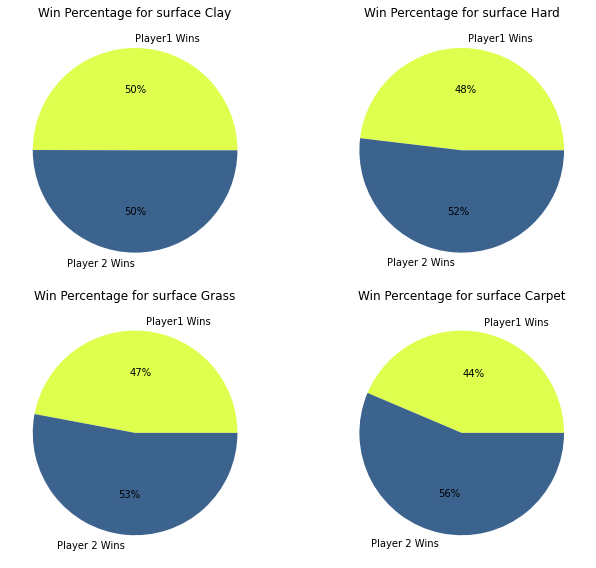

In [32]:
get_pie_surface(train)

### Federer vs the World.

Whatever drives winning, no one can deny that Roger Federer has it in spades (or maybe in rackets). Over the years many have tried to dethrown the man many consider to be the best that ever played the game. Here is a look at Federer compared to some of his top rivals over the past 20 years. 

### Explore Summary: 

### Features to Move Forward with to Modeling: 

Features to move forward with: player_1_rank_points, player_1_hand_R, player_1_hand_L, surface_Clay.

## Modeling

Before modeling, there a little bit of preparing that needs to happen. For model_prep function see model.py. 

In [54]:
def model_prep(train,validate,test):
    '''This function: 
    prepares the data for modeling'''

    # drop unused columns 
    drop_cols = ['tourney_id', 'draw_size', 'tourney_level', 'best_of', 'player_1', 'player_2',
       'player_1_age', 'player_2_age', 'player_1_hand', 'player_2_hand', 'surface',
       'player_1_ht', 'player_2_ht', 'player_1_ioc', 'player_2_ioc',
       'player_1_name', 'player_2_name', 'player_1_rank', 'player_2_rank',
       'player_2_rank_points',
       'round_ER', 'round_F', 'round_QF', 'round_R128', 'round_R16',
       'round_R32', 'round_R64', 'round_RR', 'round_SF', 'tourney_level_A', 'tourney_level_D',
       'tourney_level_F', 'tourney_level_G', 'tourney_level_M',
       'surface_Carpet', 'surface_Grass', 'surface_Hard',
       'ht_diff', 'age_diff', 'rank_diff', 'rank_points_diff', 'winner_rank', 'loser_rank', 'winner', 'no_upset', 'year']

    train = train.drop(columns=drop_cols)
    validate = validate.drop(columns=drop_cols)
    test = test.drop(columns=drop_cols)
    
    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='player_1_wins').reset_index(drop=True)
    y_train = train[['player_1_wins']].reset_index(drop=True)

    X_validate = validate.drop(columns='player_1_wins').reset_index(drop=True)
    y_validate = validate[['player_1_wins']].reset_index(drop=True)

    X_test = test.drop(columns='player_1_wins').reset_index(drop=True)
    y_test = test[['player_1_wins']].reset_index(drop=True)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test


In [55]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model_prep(train,validate,test)

In [56]:
X_train.head(1)

,player_1_rank_points,player_1_hand_R,player_1_hand_L,surface_Clay
0,3900.0,1,0,1


In [74]:
X_train.isnull().sum()

player_1_rank_points    7
player_1_hand_R         0
player_1_hand_L         0
surface_Clay            0
dtype: int64

### Baseline

Creating a baseline to compare the final model preformance to is the last step before modeling. 

The baseline that will be used here is the chance that the highest ranked player will win without an upset.

In [67]:
# look at the uno_pset column
train.no_upset.head(1)

tourney_date
2003-05-26    True
Name: no_upset, dtype: bool

In [68]:
# find the value counts for no_upset
train.no_upset.value_counts(normalize=True)

True     0.637261
False    0.362739
Name: no_upset, dtype: float64

In [69]:
# find the most frequently occurring value in no_upset
baseline = train.no_upset.mode()
baseline

0    True
dtype: bool

In [70]:
# set baseline and check accuracy
match_bsl_prediction = train.no_upset == 1
baseline_accuracy = match_bsl_prediction.mean()
# basline accuracy = 64%%
baseline_accuracy

0.637261257667182

##### The baseline accuracy is 64%.

### Decision Tree

In [72]:
def get_decision_tree(X_train, X_validate, y_train, y_validate):
    '''This function: 
    returns decision tree accuracy on train and validate data'''

    # create classifier object
    clf = DecisionTreeClassifier(max_depth=3, random_state=123)

    #fit model on training data
    clf = clf.fit(X_train, y_train)

    # print result
    print(f"Accuracy of Decision Tree on train data is {clf.score(X_train, y_train)}")
    print(f"Accuracy of Decision Tree on validate data is {clf.score(X_validate, y_validate)}")

In [73]:
get_decision_tree(X_train, X_validate, y_train, y_validate)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').